# Пункт 1. Библиотеки

In [1]:
import splitfolders
from typing import Any, Tuple
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
import os

# Пункт 2. Разбиение датасета

In [2]:
splitfolders.ratio('dataset', 'dataset_folder',
                       ratio=(0.8, 0.1, 0.1), seed=13, group_prefix=None)
import to_csv

# Пункт 3. Сверточная модель нейронной сети

In [3]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(576, 10)
        self.fc_2 = nn.Linear(10, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        
        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = torch.nn.Sigmoid()(self.fc_2(output))
        return output

# Разбиение dataset


In [4]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any = None, target_transform: Any = None) -> None:
      self.path_to_annotation_file = path_to_annotation_file
      self.dataset_info = pd.read_csv(path_to_annotation_file, delimiter=';')
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self) -> int:
      return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
      path_to_image = self.dataset_info.iloc[index, 0]
      image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
      label = self.dataset_info.iloc[index, 1]

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_Transform(label)

      return image, label

In [5]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)), 
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = CustomImageDataset('annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)

## Подключение cuda(которого у меня нет, amd)


In [6]:
device = torch.device(
    "cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)
torch.cuda.is_available()

False

# Пункт 4. загрузка выборок из dataset

In [7]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = CustomImageDataset(
    'annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)


# Пункт 5. Train loop

In [8]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 15
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.6998039215686275, train loss : 0.6217688322067261
Epoch : 1, val accuracy : 0.7233333333333333, val loss : 0.49533504247665405
Epoch : 2, train accuracy : 0.9075490196078432, train loss : 0.28361207246780396
Epoch : 2, val accuracy : 0.98, val loss : 0.15076616406440735
Epoch : 3, train accuracy : 0.9664705882352941, train loss : 0.10355066508054733
Epoch : 3, val accuracy : 0.98, val loss : 0.07392966747283936
Epoch : 4, train accuracy : 0.9676470588235293, train loss : 0.08881301432847977
Epoch : 4, val accuracy : 0.98, val loss : 0.051722146570682526
Epoch : 5, train accuracy : 0.9817647058823529, train loss : 0.0718911811709404
Epoch : 5, val accuracy : 0.98, val loss : 0.11549362540245056
Epoch : 6, train accuracy : 0.972843137254902, train loss : 0.07244350761175156
Epoch : 6, val accuracy : 0.9866666666666666, val loss : 0.04487284645438194
Epoch : 7, train accuracy : 0.9804901960784312, train loss : 0.06974378228187561
Epoch : 7, val accuracy : 0.9

# Пункт 6. Рисуем графики функций потерь

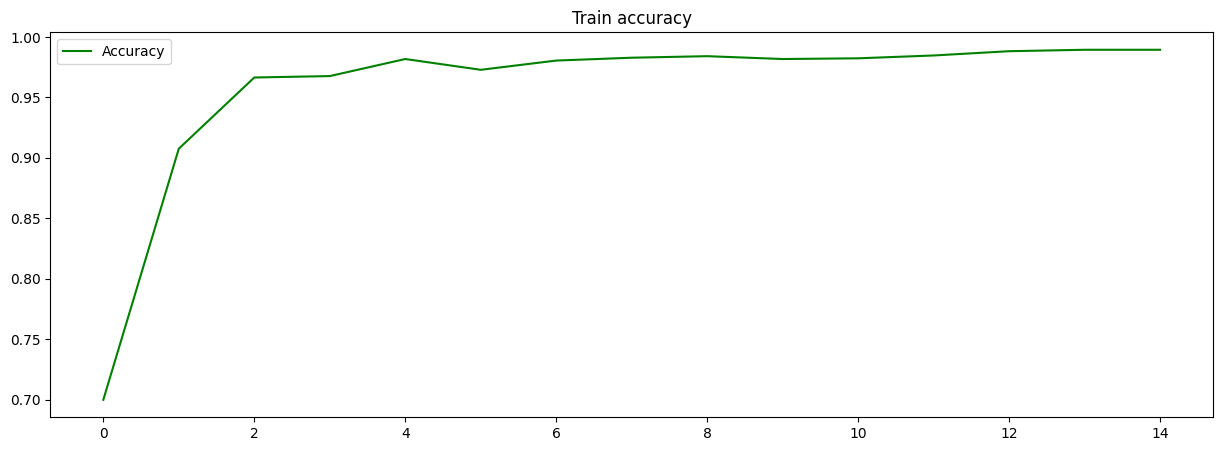

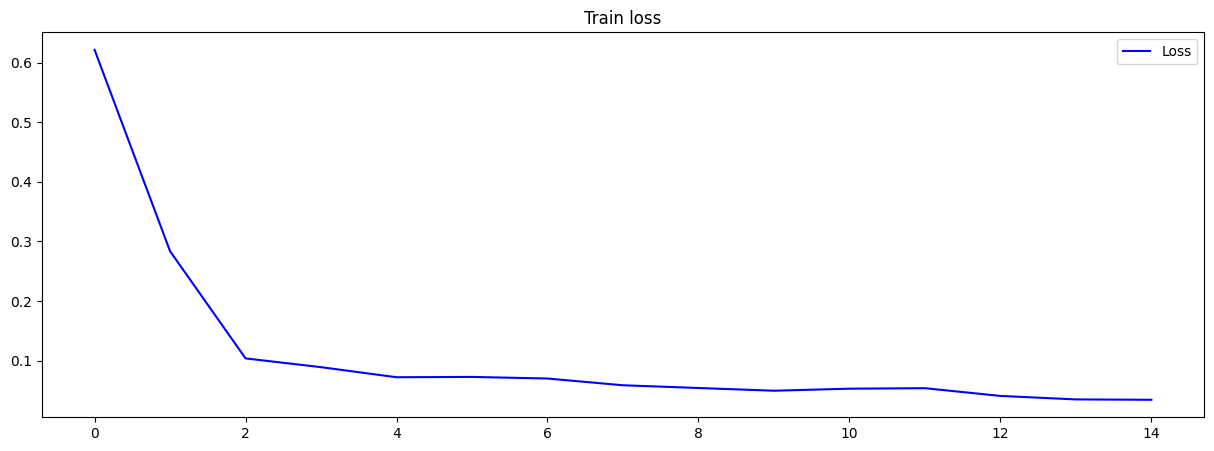

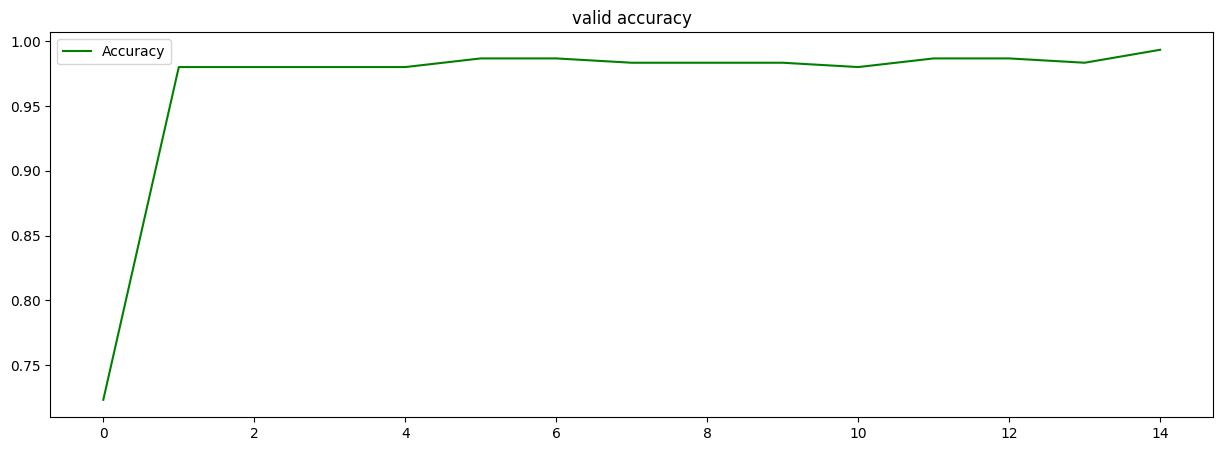

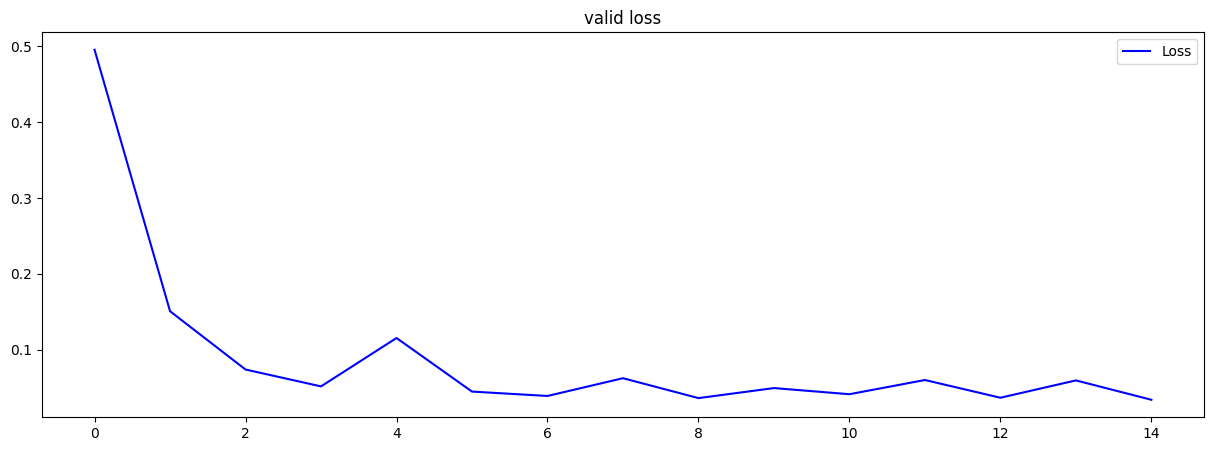

In [9]:
plt.figure(1,figsize=(15, 5))
plt.title('Train accuracy')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])

plt.figure(2,figsize=(15, 5))
plt.title('Train loss')
plt.plot(range(len(accuracy_values)), [float(value.detach())
            for value in loss_values], color="blue")
plt.legend(["Loss"])

plt.figure(3,figsize=(15, 5))
plt.title('valid accuracy')
plt.plot(range(len(accuracy_val_values)),
            accuracy_val_values, color="green")
plt.legend(["Accuracy"])

plt.figure(4,figsize=(15, 5))
plt.title('valid loss')
plt.plot(range(len(accuracy_val_values)), [float(value.detach())
            for value in loss_val_values], color="blue")
plt.legend(["Loss"])

# Пункт 7. Оценка качества модели

In [10]:
model.eval()
test_loss = 0
test_accuracy = 0

for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)

    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
        label[j]) else 0 for j in range(label.shape[0])])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
print('test_accuracy=', test_accuracy, ' ', 'test_loss=', test_loss)

test_accuracy= 0.98   test_loss= 0.026013972237706184


# Пункт 9. Сохранение модели

In [11]:
torch.save(model.state_dict(), os.path.join("dataset", "weight.pt"))

# Пункт 10. Загрузка модели

In [12]:
model = CNN()
model.load_state_dict(torch.load(os.path.join("dataset", "weight.pt")))

<All keys matched successfully>

# Проверка работоспособности

In [13]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(label.shape[0])])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)

In [14]:
test_accuracy, test_loss

(0.98, 0.026013972237706184)

# Проверка распознования

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


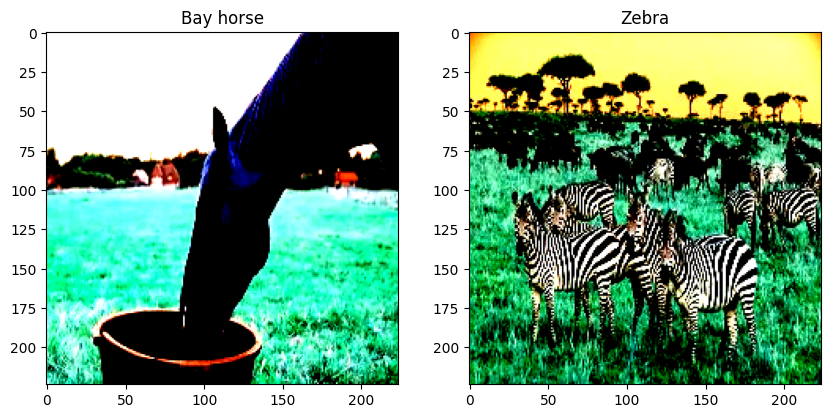

In [19]:
import random
plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, j + 1)
  plt.title("Bay horse" if (1 if  model(test_dataset[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "Zebra")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])